In [1]:
!pip install pandas numpy catboost openpyxl
from google.colab import drive
drive.mount('/content/drive')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 6.1 MB/s eta 0:00:00
Mounted at /content/drive


In [34]:
import pandas as pd

# 設定文件路徑
train_path = '/content/drive/MyDrive/Kaggle/data/train_使用經緯度_all (version 6).xlsx'
test_path = '/content/drive/MyDrive/Kaggle/data/test-reindex-test.xlsx'
valid_path = '/content/drive/MyDrive/Kaggle/data/valid.xlsx'

# 讀取資料
train = pd.read_excel(train_path)
test = pd.read_excel(test_path)
valid = pd.read_excel(valid_path)

In [35]:
import numpy as np
import pandas as pd
from datetime import datetime

# 定義基準日期
benchmark_date = pd.to_datetime('2024-01-01')

def preprocess_and_extract_features(df, benchmark_date):
    # 檢查日期是否已經轉換為西元格式
    def check_if_converted(df):
        sample_dates = df['交易年月日'].astype(str).head(3)
        for date in sample_dates:
            if len(date) == 10 and date[4] == '-' and date[7] == '-':
                return True
        return False

    # 將民國年轉換為西元年
    def convert_to_ad(year_str):
        """將民國年轉為西元年"""
        if len(year_str) == 7:  # 民國年格式YYYMMDD
            year = int(year_str[:3]) + 1911
            month = year_str[3:5]
            day = year_str[5:]
        elif len(year_str) == 6:  # 民國年格式YYMMDD
            year = int(year_str[:2]) + 1911
            month = year_str[2:4]
            day = year_str[4:]
        else:
            return None

        # 檢查月份或日期是否為 '00'
        if month == '00' or day == '00':
            return None
        else:
            return f"{year}-{month}-{day}"

    # 首先檢查是否已經是西元日期格式
    if check_if_converted(df):
        print("日期已經是西元格式，跳過轉換。")
        return df

    # 如果還沒有轉換，則進行轉換
    print("開始進行民國年到西元年的轉換...")
    df['交易年月日'] = df['交易年月日'].astype(str).apply(convert_to_ad)

    # 將轉換後的日期字串轉為 datetime 類型
    df['交易年月日'] = pd.to_datetime(df['交易年月日'], format='%Y-%m-%d', errors='coerce')

    # 去除無效日期的行
    df = df.dropna(subset=['交易年月日']).reset_index(drop=True)

    # 提取日期相關特徵
    df['交易年'] = df['交易年月日'].dt.year
    df['交易月'] = df['交易年月日'].dt.month
    df['交易日'] = df['交易年月日'].dt.day
    df['交易季度'] = df['交易年月日'].dt.quarter

    # 對月份進行正弦和餘弦變換
    df['交易月_sin'] = np.sin(2 * np.pi * df['交易月'] / 12)
    df['交易月_cos'] = np.cos(2 * np.pi * df['交易月'] / 12)

    # 計算距離基準日期的天數
    df['距離基準日期天數'] = (benchmark_date - df['交易年月日']).dt.days

    return df

# 對所有數據集應用此功能
train = preprocess_and_extract_features(train, benchmark_date)
valid = preprocess_and_extract_features(valid, benchmark_date)
test = preprocess_and_extract_features(test, benchmark_date)


開始進行民國年到西元年的轉換...
開始進行民國年到西元年的轉換...
開始進行民國年到西元年的轉換...


In [36]:
# 印出交易年月日前五行
print("交易年月日前五行:")
print(train['交易年'].head())
print(train['交易月'].head())
print(train['交易日'].head())
print(train['交易季度'].head())
print(train['交易月_sin'].head())
print(train['交易月_cos'].head())
print(train['距離基準日期天數'].head())

交易年月日前五行:
0    2020
1    2021
2    2022
3    2022
4    2023
Name: 交易年, dtype: int32
0    8
1    9
2    7
3    5
4    2
Name: 交易月, dtype: int32
0    30
1    14
2     8
3     4
4     9
Name: 交易日, dtype: int32
0    3
1    3
2    3
3    2
4    1
Name: 交易季度, dtype: int32
0   -0.866025
1   -1.000000
2   -0.500000
3    0.500000
4    0.866025
Name: 交易月_sin, dtype: float64
0   -5.000000e-01
1   -1.836970e-16
2   -8.660254e-01
3   -8.660254e-01
4    5.000000e-01
Name: 交易月_cos, dtype: float64
0    1219
1     839
2     542
3     607
4     326
Name: 距離基準日期天數, dtype: int64


In [37]:
import re
import pandas as pd

def chinese_to_num(chinese_str):
    """將中文數字轉換為阿拉伯數字，並處理地下層"""
    chinese_num_map = {
        '零': 0, '一': 1, '二': 2, '三': 3, '四': 4, '五': 5, '六': 6, '七': 7, '八': 8, '九': 9,
        '十': 10, '十一': 11, '十二': 12, '十三': 13, '十四': 14, '十五': 15, '十六': 16, '十七': 17, '十八': 18, '十九': 19,
        '二十': 20, '二十一': 21, '二十二': 22, '二十三': 23, '二十四': 24, '二十五': 25, '二十六': 26, '二十七': 27, '二十八': 28, '二十九': 29,
        '三十': 30, '三十一': 31, '三十二': 32, '三十三': 33, '三十四': 34, '三十五': 35, '三十六': 36, '三十七': 37, '三十八': 38, '三十九': 39,
        '四十': 40, '四十一': 41, '四十二': 42, '四十三': 43, '四十四': 44, '四十五': 45, '四十六': 46, '四十七': 47, '四十八': 48, '四十九': 49,
        '五十': 50, '五十一': 51, '五十二': 52, '五十三': 53, '五十四': 54, '五十五': 55, '五十六': 56, '五十七': 57, '五十八': 58, '五十九': 59, '六十': 60
    }

    # 處理地下層數
    if isinstance(chinese_str, str) and chinese_str.startswith('地下'):
        return -chinese_num_map.get(chinese_str[2:], 0)

    # 將「層」去掉後轉換中文數字
    return chinese_num_map.get(chinese_str.replace('層', ''), None)

def create_floor_features(table):
    # 填充空值以避免處理空值時出錯
    table['移轉層次'] = table['移轉層次'].fillna('')

    # 節省內存處理，逐行處理，並防止內存溢出
    def process_row(row):
        floor_str = row['移轉層次']
        total_floors = row['總樓層數']

        # 處理 "全"、"整棟"、"全棟"、"全部" 等情況
        if any(keyword in floor_str for keyword in ['全', '整棟', '全棟', '全部']):
            floor_num = total_floors  # 如果是 "全" 表示樓層數等於總樓層數
        else:
            # 處理 "1-2層" 或 "1，2層" 等範圍情況，取範圍中的最大值
            range_match = re.findall(r'\d+', floor_str)
            if range_match:
                floor_num = max([int(x) for x in range_match])
            else:
                # 嘗試將中文數字轉換為數字
                floor_num = chinese_to_num(floor_str)

        # 頂樓判斷和樓層比例計算
        if total_floors > 0 and floor_num is not None:
            top_floor = (floor_num == total_floors)
            floor_ratio = floor_num / total_floors
        else:
            top_floor = False
            floor_ratio = 0

        return pd.Series([top_floor, floor_num, floor_ratio])

    # 使用 apply 逐行處理，但返回多個新欄位，避免多次操作表格
    table[['top_floor', '移轉層次_數值', 'floor_ratio']] = table.apply(process_row, axis=1)

    return table
train = create_floor_features(train)
valid = create_floor_features(valid)
test = create_floor_features(test)

# 查看結果
print(train[['移轉層次', '總樓層數', 'top_floor', 'floor_ratio']].head())
print(valid[['移轉層次', '總樓層數', 'top_floor', 'floor_ratio']].head())
print(test[['移轉層次', '總樓層數', 'top_floor', 'floor_ratio']].head())


  移轉層次  總樓層數  top_floor  floor_ratio
0   五層    10      False          0.5
1   四層     5      False          0.8
2   三層     5      False          0.6
3   二層     5      False          0.4
4   四層     5      False          0.8
  移轉層次  總樓層數  top_floor  floor_ratio
0   一層     4      False     0.250000
1   十層    15      False     0.666667
2   二層     7      False     0.285714
3   六層    15      False     0.400000
4    全     4       True     1.000000
   移轉層次  總樓層數  top_floor  floor_ratio
0     全     3       True     1.000000
1    八層    12      False     0.666667
2   十六層    25      False     0.640000
3  二十一層    29      False     0.724138
4   十二層    15      False     0.800000


In [10]:
# 下載台北思源黑體
!wget -O TaipeiSansTCBeta-Regular.ttf https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_&export=download
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.font_manager import fontManager

fontManager.addfont('TaipeiSansTCBeta-Regular.ttf')
mpl.rc('font', family='Taipei Sans TC Beta')

--2024-10-23 08:02:06--  https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_
Resolving drive.google.com (drive.google.com)... 173.194.212.139, 173.194.212.102, 173.194.212.138, ...
Connecting to drive.google.com (drive.google.com)|173.194.212.139|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_ [following]
--2024-10-23 08:02:06--  https://drive.usercontent.google.com/download?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 108.177.12.132, 2607:f8b0:400c:c08::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|108.177.12.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20659344 (20M) [application/octet-stream]
Saving to: ‘TaipeiSansTCBeta-Regular.ttf’

TaipeiSansTCBeta-Re 100%[===================>]  19.70M  --.-KB/s    in 0.1s    

2024-10-23 08

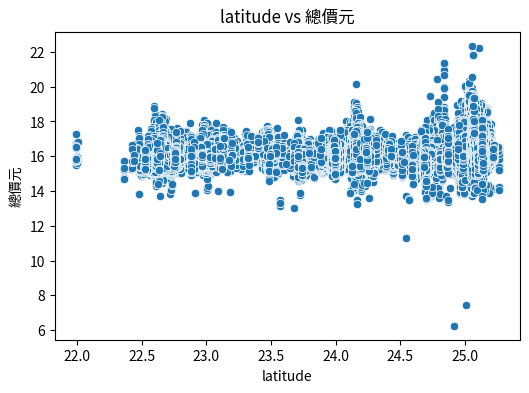

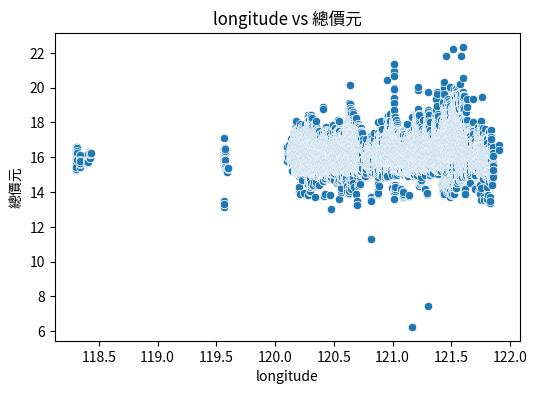

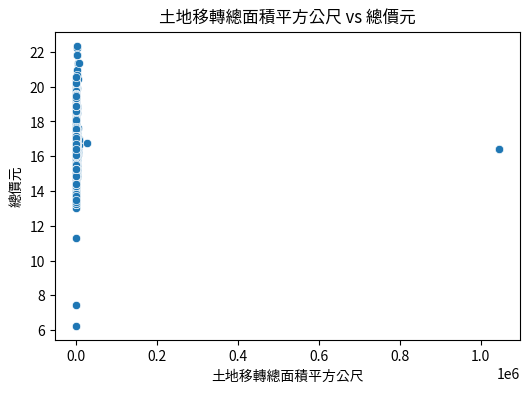

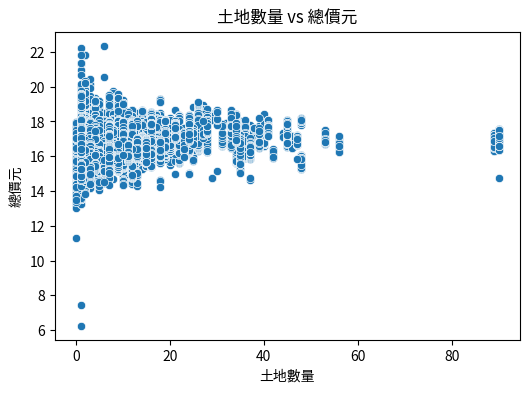

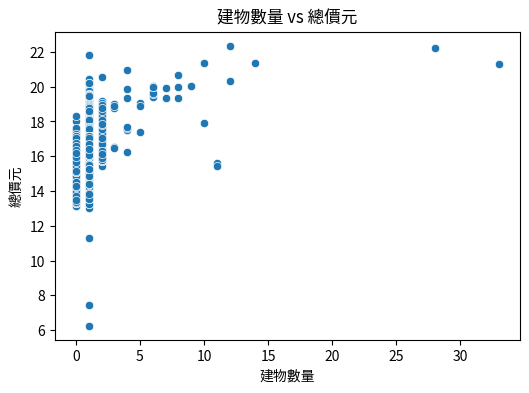

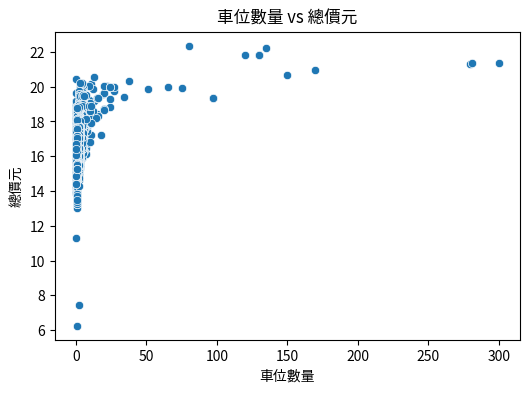

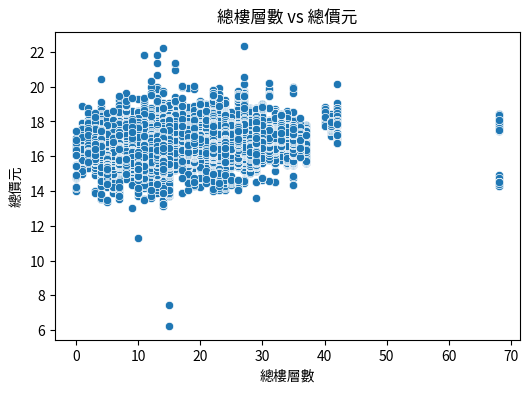

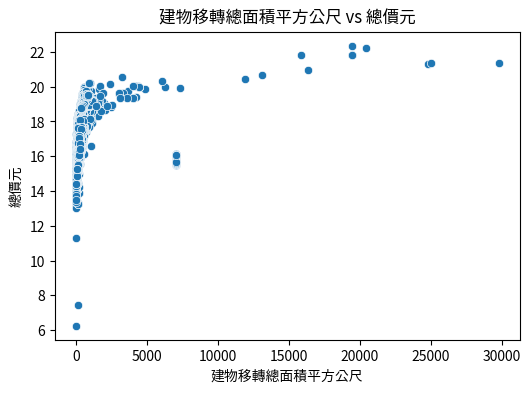

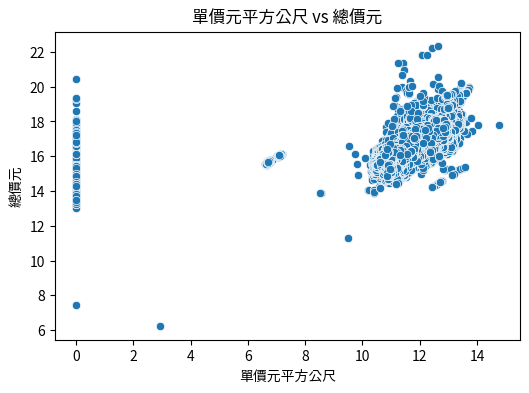

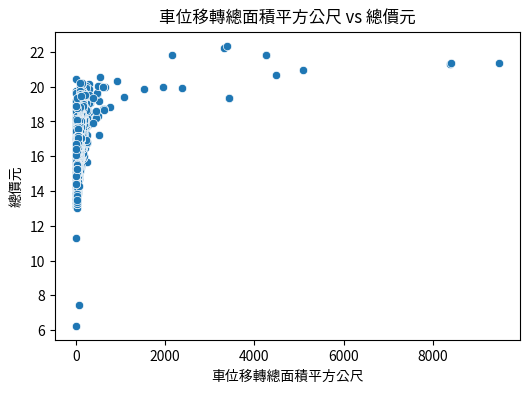

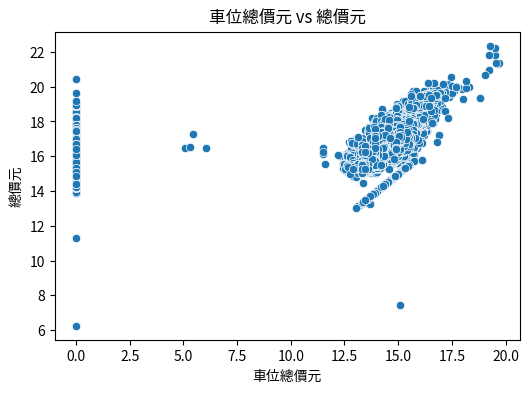

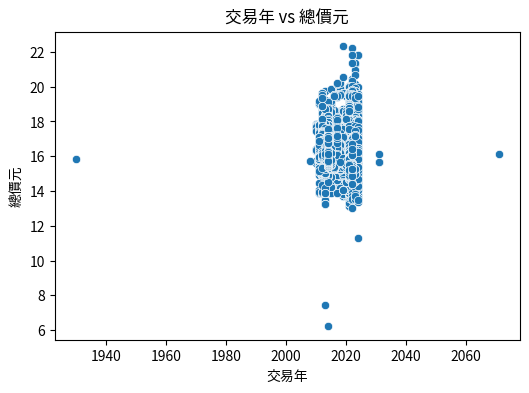

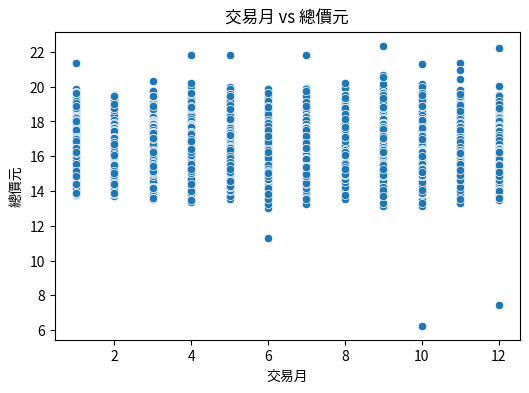

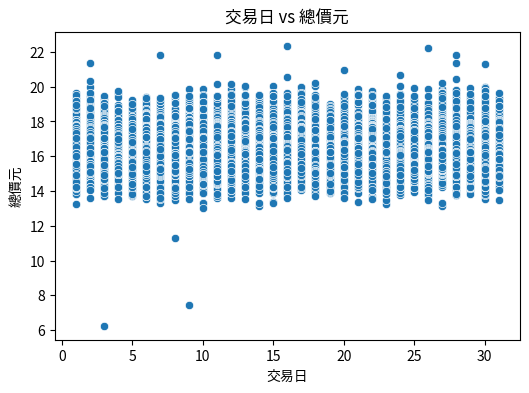

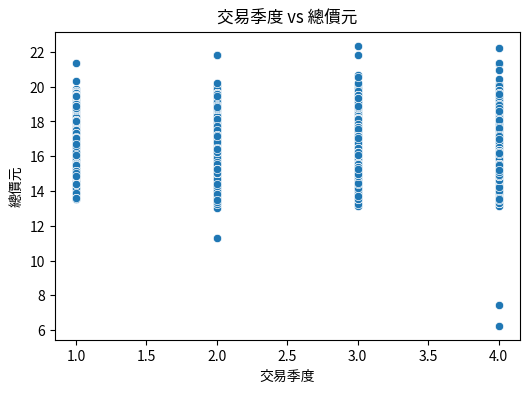

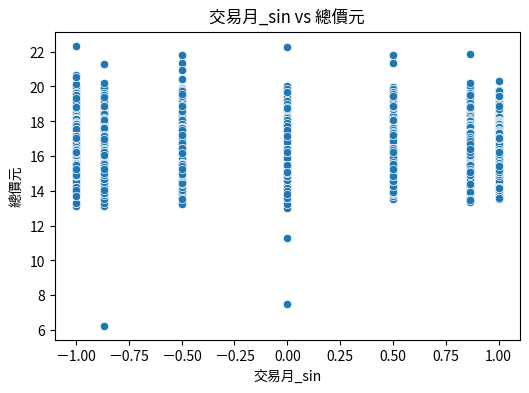

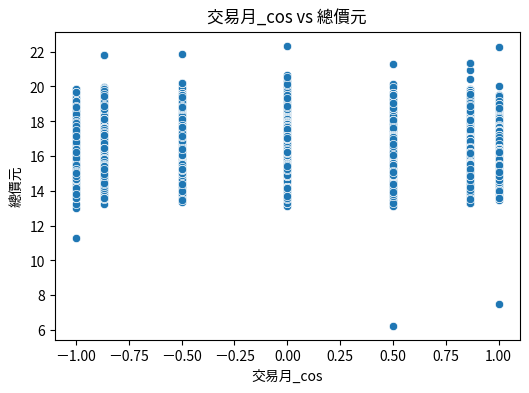

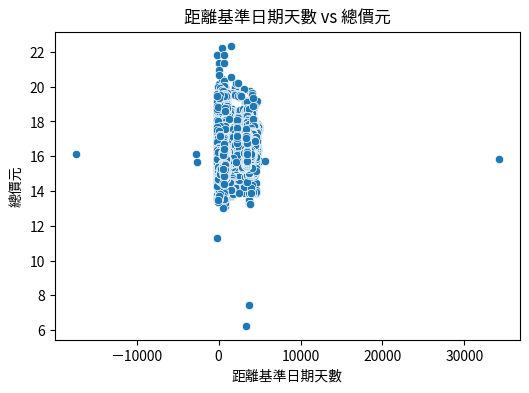

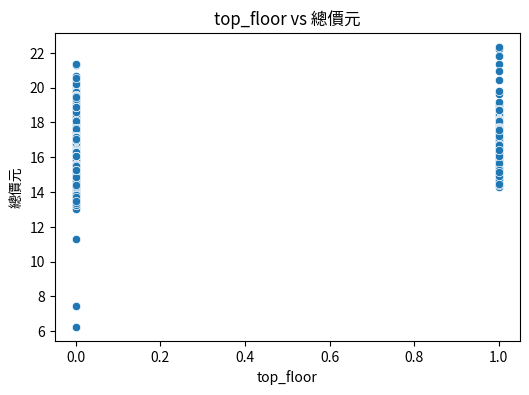

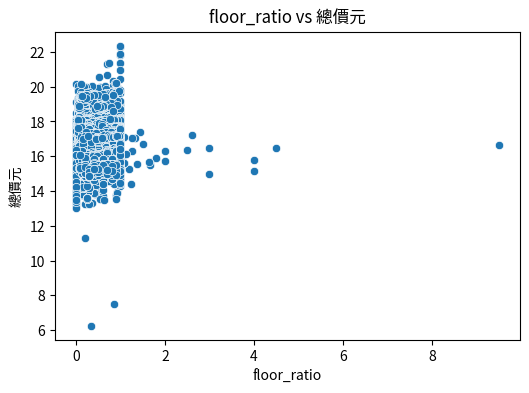

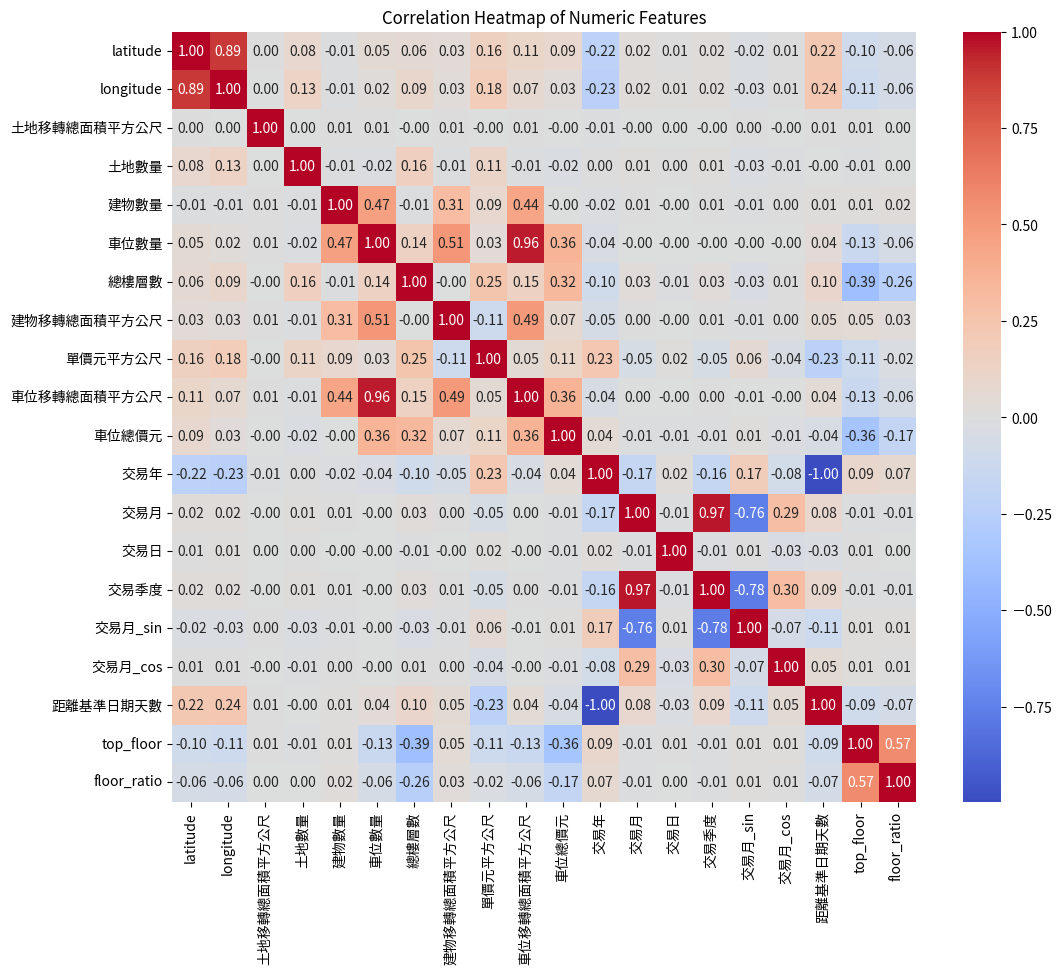

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns
# 數字特徵
numeric_columns = ['latitude', 'longitude', '土地移轉總面積平方公尺',
                   '土地數量', '建物數量', '車位數量', '總樓層數', '建物移轉總面積平方公尺',
                   '單價元平方公尺', '車位移轉總面積平方公尺', '車位總價元',
                   '交易年', '交易月', '交易日', '交易季度', '交易月_sin', '交易月_cos',
                   '距離基準日期天數', 'top_floor', 'floor_ratio']

# 1. Visualize the relationship between numeric features and target variable '總價元'
def plot_numeric_vs_target(df, target_column, numeric_columns):
    """Creates scatter plots between each numeric feature and the target variable."""
    for column in numeric_columns:
        plt.figure(figsize=(6, 4))
        sns.scatterplot(data=df, x=column, y=target_column)
        plt.title(f'{column} vs {target_column}')
        plt.xlabel(column)
        plt.ylabel(target_column)
        plt.show()
# 2. Plot correlation heatmap for numeric features
def plot_correlation_heatmap(df, numeric_columns):
    """Creates a heatmap showing correlations between numeric features."""
    plt.figure(figsize=(12, 10))
    corr = df[numeric_columns].corr()
    sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title('Correlation Heatmap of Numeric Features')
    plt.show()

# 使用這些函數繪製關係圖和熱圖
# For example, assuming the target variable is '總價元':
target_column = '總價元'
plot_numeric_vs_target(train, target_column, numeric_columns)
plot_correlation_heatmap(train, numeric_columns)

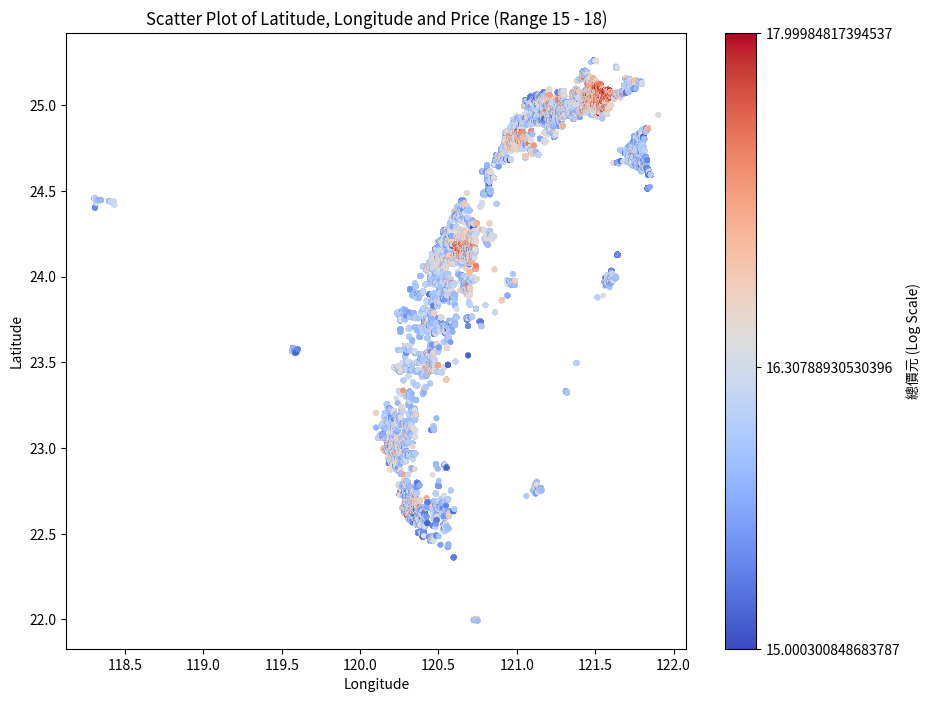

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Function to plot latitude, longitude, and price with a specific range of target values
def plot_lat_lon_vs_price(df, lat_column, lon_column, target_column, min_price, max_price):
    # Filter the dataframe for the desired range of prices
    filtered_df = df[(df[target_column] >= min_price) & (df[target_column] <= max_price)]

    plt.figure(figsize=(10, 8))

    # Normalize the target variable using a logarithmic scale to improve contrast
    norm = plt.Normalize(vmin=np.log1p(filtered_df[target_column].min()), vmax=np.log1p(filtered_df[target_column].max()))

    # Plot scatter with adjusted colormap and normalized color scale
    scatter = plt.scatter(filtered_df[lon_column], filtered_df[lat_column],
                          c=np.log1p(filtered_df[target_column]), cmap='coolwarm', s=10, norm=norm)

    # Add color bar with the original price scale
    cbar = plt.colorbar(scatter)
    cbar.set_label('總價元 (Log Scale)')
    cbar.set_ticks([np.log1p(filtered_df[target_column].min()), np.log1p(filtered_df[target_column].median()), np.log1p(filtered_df[target_column].max())])
    cbar.set_ticklabels([filtered_df[target_column].min(), filtered_df[target_column].median(), filtered_df[target_column].max()])

    # Set plot title and labels
    plt.title(f'Scatter Plot of Latitude, Longitude and Price (Range {min_price} - {max_price})')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.show()

# 使用這個函數來繪製經緯度與價格的散落圖，顯示總價元範圍在 10 到 20 之間
plot_lat_lon_vs_price(train, 'latitude', 'longitude', '總價元', 15, 18)


In [25]:
import pandas as pd

# 確保完整顯示所有欄位
pd.set_option('display.max_columns', None)  # 顯示所有列
pd.set_option('display.width', 1000)  # 增加顯示寬度來顯示更多內容

# 顯示 X_train 的前 5 行數據
print(train.head())

         總價元 鄉鎮市區          交易標的   縣市  縣市鄉鎮市區              土地位置建物門牌      路名      縣市鄉鎮市區路名   latitude   longitude  土地移轉總面積平方公尺 都市土地使用分區 非都市土地使用分區 非都市土地使用編定 交易年月日  土地數量  建物數量  車位數量 移轉層次  總樓層數           建物型態 主要用途    主要建材  建物移轉總面積平方公尺  建物現況格局-房  建物現況格局-廳  建物現況格局-衛 建物現況格局-隔間    單價元平方公尺  車位類別  車位移轉總面積平方公尺      車位總價元  top_floor  移轉層次_數值  floor_ratio  交易年  交易月  交易日  交易季度  交易月_sin  交易月_cos  距離基準日期天數
0  16.008281  桃園區  房地(土地+建物)+車位  桃園市  桃園市桃園區  桃園市桃園區同安段1508地號A5棟5樓     同安段     桃園市桃園區同安段  25.016970  121.306370        29.88        住       NaN       NaN   NaT     1     1     1   五層    10  華廈(10層含以下有電梯)  住家用  鋼筋混凝土造       131.74         3         2         2         有  11.301167  坡道平面        43.87  14.430697      False      5.0          0.5  NaN  NaN  NaN   NaN      NaN      NaN       NaN
1  15.585365  金寧鄉     房地(土地+建物)  金門縣  金門縣金寧鄉     金門縣金寧鄉寧湖二劃測段390地號  寧湖二劃測段  金門縣金寧鄉寧湖二劃測段  24.456577  118.305852        34.28       其他       NaN       NaN   NaT     1     1     0   四層     5  華廈(10層含以下有電梯)  住家用  鋼筋混凝